# HR Separation Project
----
## Beginning some more rigorous approaches to analysis of an already processed file.


### load the prerequisite modules

In [1]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

In [2]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [3]:
os.chdir(repodir)
import bear.bear as br

In [4]:
os.chdir(stgdir1local)

In [5]:
%ls

c2_EAS.ssv                   employee_dataframe.tsv
cp_SR_EAS.txt                employee_df_1.csv
empl1_aaf_1_ci.pkl           employee_df_2.csv
empl_aaf_1_hazards.pkl       employee_table_summary_3.csv
empl_aaf_1.pkl               employee_table_summary.csv
employee_dataframe3.ssv      fourthousand_rfsc1.RData
employee_dataframe4.tsv      fthou_rf_sepTen.RData
employee_dataframe5.tsv      histret_mod
employee_dataframe6.tsv      SBR
employee_dataframe7long.tsv  sbr_mod
employee_dataframe8.tsv      tree0.dot
employee_dataframe9.tsv      tree.dot
employee_dataframe.ssv       us_unemployment_monthly_seas.csv*


In [ ]:
empl1 = pd.read_csv('employee_dataframe.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str})
empl1.drop('Unnamed: 0',axis=1,inplace=True)
empl1.SKEY.head()

###load the datafile

In [6]:
datafile = 'employee_dataframe9.tsv'
empl_bene = pd.read_csv(datafile,sep='\t',dtype={'KEY':np.str,'zip5':np.str,'SKEY':np.str})
empl_bene.drop('Unnamed: 0',axis=1,inplace=True)
# drop per_org --> universally EMP
empl_bene.drop('PER_ORG',axis=1,inplace=True)
print empl_bene.shape

(199346, 188)


### specify the column information

In [7]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            r_index =random.randint(0,nrow)
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[r_index]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    return summary_df

In [8]:
sdf = summarize_dataframe2(empl_bene)

ACTRES1 object 10 	25519
ACTRES10 object 120322 	12096
ACTRES2 object 30258 	22254
ACTRES3 object 56780 	19758
ACTRES4 object 74550 	18074
ACTRES5 object 85571 	14494
ACTRES6 object 93133 	11929
ACTRES7 object 99988 	12926
ACTRES8 object 107671 	11037
ACTRES9 object 113909 	11376
ADDRCNT1 float64 111 	6
ADDRCNT10 float64 111 	15
ADDRCNT3 float64 111 	10
ADDRCNT5 float64 111 	12
ADDRESS1 object 113 	190400
ADDRESS2 object 185702 	7859
ANNUAL_RT float64 0 	123689
Age_tdelta object 0 	19297
Age_years float64 0 	19297
BIRTHDATE object 0 	24349
BOX1 float64 69984 	4
BOX10 float64 127920 	4
BOX2 float64 61813 	4
BOX3 float64 78216 	4
BOX4 float64 89163 	4
BOX5 float64 96822 	4
BOX6 float64 103260 	4
BOX7 float64 110764 	4
BOX8 float64 116598 	4
BOX9 float64 122605 	4
COMPANY int64 0 	7
hourly_comp int64 0 	2
CUR_DEPT_MOS float64 0 	5388
CUR_EFUNC_MOS float64 0 	7917
CUR_FUNC_MOS float64 0 	9046
CUR_GRADE_MOS float64 0 	4876
CUR_JOB_MOS float64 0 	6476
CUR_LOC_MOS float64 0 	7883
DEPTCNT1 int

In [9]:
sdf.head()

,Column,datatype,nmissing,arity,accepted values
0,ACTRES1,object,10,25519,None
1,ACTRES10,object,120322,12096,None
2,ACTRES2,object,30258,22254,None
3,ACTRES3,object,56780,19758,None
4,ACTRES4,object,74550,18074,None


In [10]:
### confirm that no values are missing: 
if sdf.nmissing.sum()== 0:
    print "There are no missing values in the dataframe"

## Look at building a network for current employees

In [32]:
empl1.status.value_counts()

1    129613
0     69806
dtype: int64

In [33]:
current = empl1[empl1.status == 0].copy()

In [34]:
number_of_unique_supervisors = len(current.SKEY.unique())
print number_of_unique_supervisors

7985


### find the top of this network

In [35]:
ceo_key = current[current.SKEY.isnull()].KEY.values[0]
print ceo_key
print current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']]

230212589367392
       Age_years  Tenure_months  COMPANY GRADE  ANNUAL_RT              KEY
72082  64.414738      472.02612        1    L1    1750000  230212589367392


#### first try:

In [36]:
import networkx as nx
G=nx.Graph()

In [37]:
current[current.KEY==ceo_key].DIRECT_RPT_CNT

72082   NaN
Name: DIRECT_RPT_CNT, dtype: float64

In [39]:
current[current.SKEY==ceo_key]['KEY']

6606      737799909775052
48657     309708826853758
86836     131586418548406
142939    195258013529357
170992    603471382336445
181273    881947698482288
197267    264691242605770
Name: KEY, dtype: object

In [38]:
len(current.KEY.unique())

69806

In [80]:
for key in current.KEY.unique()[:40]:
    supkey = current[current.KEY == key].SKEY.values[0]
    if supkey not in list(extraSKEYset):
        print key, supkey
        edge = (key,supkey)

490903510940682 341940748664523
850716555421574 695830568995248
213029456889736 295711092322930
765210492427093 487525711994397
297986222569824 821086056912824
238171549159182 376000762626529
417845256355519 464408479381543
545043537647018 936521995783095
639741570055364 548312217718136
118502797614086 118778266067979
614175683639094 640297610610862
887695397663720 927804536152540
789225798933406 882560782079846
353948927183612 873205531795139
406631784702945 259352636178654
415914991598537 960664279740613
511033925931451 176179836586201
904574965548038 907994693102313
410277538658249 669467713995589
904437336094881 484497867750236
109248166489065 205464591833513
293390113996989 655237257785740
764490464126920 575040451984406
942168768468391 963526995835606
354699357577925 936881977569723
27791840502895 128977640126356
760120148193147 982231824184876
495367733992342 924915584234947
231319244127404 943581196453227
853140060721496 506096822910987
382008131305691 291754381401350
526162207

In [81]:
G.clear()
G.number_of_nodes()

0

In [82]:
for key in current.KEY.unique():
    supkey = current[current.KEY == key].SKEY.values[0]
    if supkey not in list(extraSKEYset):
        #print key, supkey
        edge = (key,supkey)
    #print key, supkey
    #edge = (key,supkey)
        G.add_edge(*edge)
    
print G.number_of_nodes()
print G.number_of_edges()


69697
69669


In [46]:
G.remove_node(np.nan) # get rid of the node from ceo to here

In [83]:
G.neighbors(ceo_key)

['264691242605770',
 '881947698482288',
 '131586418548406',
 '195258013529357',
 '309708826853758',
 '603471382336445',
 '737799909775052']

In [84]:
G.neighbors(G.neighbors(ceo_key)[0])

['411491708090292',
 '615267030715601',
 '230212589367392',
 '436256937420115',
 '817257751159956',
 '838427157531691']

In [88]:
#G.graph['employees'] = 'list'

{}

In [92]:
G.adjacency_list()[0]

['854660831324133']

In [97]:
G.degree('854660831324133')#s()[0]#('854660831324133')

10

In [98]:
G.neighbors('854660831324133')

['914822502487722',
 '156732029820202',
 '171368124974597',
 '293218779979841',
 '124448826594487',
 '755961730962601',
 '571440945179873',
 '681978314035562',
 '916926607450902',
 '468252626000090']

# try to construct a hierarchical graph using blockmodel 

In [102]:
nx.__version__


'1.9.1'

In [107]:
subGraphs = [subg for subg in nx.connected_component_subgraphs(G)]

In [108]:
# Extract largest connected component into graph H
H=subGraphs[0]
H.number_of_nodes()


69337

In [109]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [110]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=1.15))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(n)
    return list(partition.values())

In [ ]:
 # Draw original graph
pos=nx.spring_layout(G,iterations=100)
fig=plt.figure(1,figsize=(6,10))
ax=fig.add_subplot(211)
nx.draw(G,pos,with_labels=False,node_size=8)
plt.xlim(0,1)
plt.ylim(0,1)

# look to see if there are SKEY values that are not KEY values <-- corresponds to a mis-identification of Supervisors

In [52]:
print len(current.SKEY.unique())
currentSKEYset = set(current.SKEY.unique())
currentKEYset = set(current.KEY.unique())
# difference
extraSKEYset = currentSKEYset - currentKEYset
print len(extraSKEYset)

16


In [61]:
current[current.SKEY == list(extraSKEYset)[4]].KEY

32430     402245888673815
36373     760919157304298
58360     409302843459557
101875    479560227822308
135940     18643642784396
159664    196095957046419
176858    726173508319153
Name: KEY, dtype: object

In [53]:
extraSKEYset

{nan,
 '182692648928004',
 '219174679005134',
 '294168883140278',
 '376077392313665',
 '407623755004082',
 '423486191976576',
 '4904977979560',
 '498297705547091',
 '544781312600142',
 '546480249867998',
 '633397990666981',
 '781960035572741',
 '801927175280604',
 '948253900719925',
 '981495664912041'}

### so try it based upon starting at top

In [71]:
current[current.SKEY==ceo_key].KEY.values.tolist()

#for key in current.KEY.unique()[:10]:
#    supkey = current[current.KEY == key].SKEY.values[0]
#    print key, supkey
#    edge = (key,supkey)

['737799909775052',
 '309708826853758',
 '131586418548406',
 '195258013529357',
 '603471382336445',
 '881947698482288',
 '264691242605770']

In [77]:
def get_list_of_supervisees(skey,df):
    supervisees_list = current[current.SKEY==skey].KEY.values.tolist()
    return supervisees_list

In [78]:
for a in get_list_of_supervisees(ceo_key,current):
    b = get_list_of_supervisees(a,current)
    print ceo_key, a, 

230212589367392 737799909775052 ['778246226617250', '833584495742612', '221327299820877', '49695066665157', '162457082961899']
230212589367392 309708826853758 ['966160380731411', '629673229358007', '257140146688158', '327958288289587', '996296803930913', '878219024221515']
230212589367392 131586418548406 ['49610022012894', '509833770575856', '429253692007276', '925316915346923', '789806018485597', '616873900227656']
230212589367392 195258013529357 []
230212589367392 603471382336445 ['889443126921283', '437449985387479', '158506991881182', '546233367894885', '408224727682874', '590707344743753']
230212589367392 881947698482288 ['405064530859266', '465662928049296', '308338758679265', '784776492409770', '917403581513746', '539640774736014', '650478767068348']
230212589367392 264691242605770 ['615267030715601', '817257751159956', '436256937420115', '411491708090292', '838427157531691']


## Fishing expedition

In [115]:
sum(empl1.BIRTHDATE=='1974-01-10 00:00:00')

7

In [118]:
empl_Jan1074_idx = empl1[empl1.BIRTHDATE=='1974-01-10 00:00:00'].index


In [141]:
empl1.ix[empl_Jan1074_idx][['GRADE','KEY','status','HIRE_DT','SKEY','JOB_FAMILY']]

,GRADE,KEY,status,HIRE_DT,SKEY,JOB_FAMILY
10527,RC3,449922919017227,0,1998-09-08 00:00:00,854470014970037,BSUSCA
23483,RD2,316924511602579,0,2013-05-06 00:00:00,148161780158,RESTAT
23535,MA1,503151859391086,1,1993-05-17 00:00:00,314896487777539,NaN
52253,MG2,300271194102369,0,1999-06-14 00:00:00,711538890242362,CTNTMG
81193,RE3,308452940689611,0,1995-05-22 00:00:00,953158934578839,SAWEB
157467,PA2,653011049448052,0,2005-12-19 00:00:00,879760487880446,UNSRST
176663,RB1,309633856783451,1,1998-06-12 00:00:00,582290634784052,CLMREP


In [127]:
key_me = empl1.ix[empl_Jan1074_idx[1]].KEY
key_jeff = empl1.ix[empl_Jan1074_idx[1]].SKEY
print key_me, key_jeff


316924511602579 148161780158


In [205]:
empl1[empl1.KEY.isin(G[key_jeff].keys())][['Age_years','GRADE','HIRE_DT','SAL1','JOBCODE','JOB_FAMILY','JOB_FUNCTION']]

,Age_years,GRADE,HIRE_DT,SAL1,JOBCODE,JOB_FAMILY,JOB_FUNCTION
4262,29.689864,RD2,2013-05-06 00:00:00,98192.00,1460,RESTAT,PTD
23483,40.975516,RD2,2013-05-06 00:00:00,96995.00,1460,RESTAT,PTD
42392,47.297344,MG5,1995-01-16 00:00:00,120460.89,9442,DIRSTR,MGT
102478,25.043635,RD2,2009-06-15 00:00:00,78000.00,1460,RESTAT,PTD
190741,25.500866,RD2,2012-05-21 00:00:00,65875.00,1460,RESTAT,PTD


In [143]:
len(current[current.JOB_FAMILY=='RESTAT'])

61

In [144]:
current[current.JOB_FAMILY=='RESTAT'].GRADE.value_counts()

RD2    38
RD3    17
RD4     5
RD1     1
dtype: int64

In [145]:
current[current.JOB_FAMILY=='RESTAT'].JOBCODE.value_counts()

1460    38
1446    17
1445     5
1461     1
dtype: int64

In [156]:
current[current.JOB_FAMILY=='RESTAT'].groupby('JOBCODE')['SAL1'].agg([np.size,np.min,np.median,np.max, np.mean,  np.std])
# gives the counts, mean, median and std for each jobcode

,size,amin,median,amax,mean,std
JOBCODE,,,,,,
1445,5,109128.99,124256.32,130621.51,120831.440000,9172.266723
1446,17,82520.00,93974.27,114796.37,95679.442941,8914.250178
1460,38,63344.54,73605.95,98192.00,74100.111053,8468.908543
1461,1,64000.00,64000.00,64000.00,64000.000000,NaN


38
17


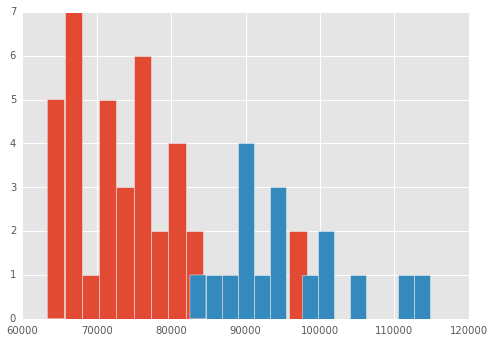

In [147]:
# how many in jobcode 1460?
print len(current[current.JOBCODE == 1460])
current[current.JOBCODE==1460].SAL1.hist(bins=15)
print len(current[current.JOBCODE == 1446])
current[current.JOBCODE==1446].SAL1.hist(bins=15)

252


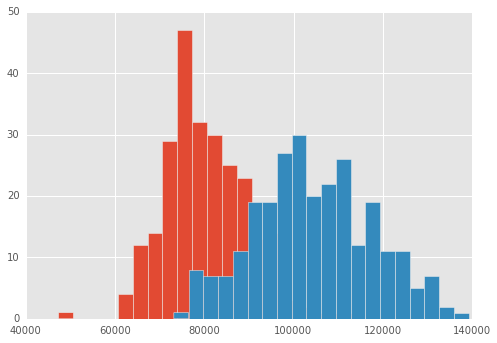

In [140]:
current[current.GRADE=='RD2'].SAL1.hist(bins=20)
print len(current[current.GRADE=='RD2'])
current[current.GRADE=='RD3'].SAL1.hist(bins=20)

265


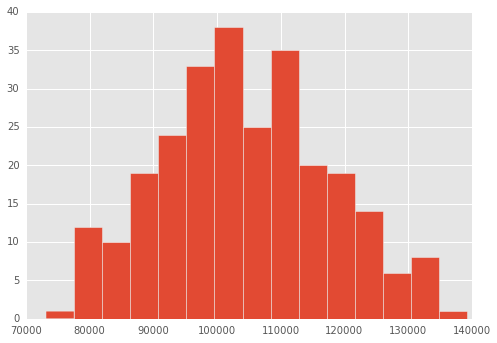

In [139]:
current[current.GRADE=='RD3'].SAL1.hist(bins=15)
print len(current[current.GRADE=='RD3'])

In [157]:
sum(current['GRADE']=='RE3')

1783

In [158]:
current[current['GRADE']=='RE3']['JOB_FAMILY'].value_counts()

SAWEB     394
TASTSP    189
SAMNFR    179
TATCCD    168
TASCUR    124
ANLOPX    103
SABSIN     89
TAENVT     66
TADDMG     65
TANTWK     58
EUCAST     54
TAPERF     35
SACLSV     34
DSDBAN     32
DSDDSN     27
TAPVSG     24
TAHRDW     23
RSYADM     15
SYSADT     13
CHGAYS     13
MKTDBA     10
DSDBSA      8
BANKTA      7
ESSPTA      6
SDCORD      5
DTASIU      5
REDASP      4
ALMGAN      4
HRBOTA      4
EUCANS      4
STMDSA      4
URSCHA      3
SFTDVP      3
PADBAN      3
EUCACF      2
MRSFST      2
RSCHAD      2
EXECCA      1
RSANST      1
dtype: int64

In [163]:
current[(current['JOB_FAMILY']=='DSDDSN')&(current['GRADE']=='RE3')].groupby('SKEY').size()#[['KEY','SKEY','HIRE_DT','Age_years']]

SKEY
161211433895496    2
208550388090569    1
352364378679713    1
424581573542478    1
426470777684111    1
489494459931503    1
548312217718136    6
561781181749786    3
68540412498890     1
735551670536190    1
933192385795150    1
941452731816775    7
980940528205103    1
dtype: int64

In [166]:
skey_check = current[(current['JOB_FAMILY']=='DSDDSN')&(current['GRADE']=='RE3')].SKEY.unique().tolist()

In [176]:
for key in skey_check:
    
    n_left = len(empl1[(empl1.SKEY==key)&(empl1.status==1)]>0)
    if n_left > 0:
        print key,"\n"
        for empl_key in empl1[(empl1.SKEY==key)&(empl1.status==1)].KEY.tolist():
            print empl1[empl1.KEY==empl_key][['HIRE_DT','TERMINATION_DT','status','GRADE','Age_years']]
    #print key,n_left
        #print "\t", current[current.KEY==key][['HIRE_DT','Age_years']]
        #print current[current.KEY==key][['HIRE_DT','Age_years','CUR_DEPT_MOS','CUR_FUNC_MOS']]

548312217718136 

                   HIRE_DT       TERMINATION_DT  status GRADE  Age_years
55962  1992-02-03 00:00:00  2009-05-31 00:00:00       1   RE3  62.454397
                   HIRE_DT       TERMINATION_DT  status GRADE  Age_years
65897  1994-10-03 00:00:00  2011-03-21 00:00:00       1   RE2  45.539607
                    HIRE_DT       TERMINATION_DT  status GRADE  Age_years
129660  1997-09-08 00:00:00  2005-06-22 00:00:00       1   PB3  30.253872
                    HIRE_DT       TERMINATION_DT  status GRADE  Age_years
176718  1992-05-11 00:00:00  2003-02-28 00:00:00       1   PB3  63.018406
933192385795150 

                   HIRE_DT       TERMINATION_DT  status GRADE  Age_years
33951  1968-06-10 00:00:00  2011-04-30 00:00:00       1   RA4  60.688447
                   HIRE_DT       TERMINATION_DT  status GRADE  Age_years
75986  2001-06-18 00:00:00  2009-09-10 00:00:00       1   PB4   48.17895
                    HIRE_DT       TERMINATION_DT  status GRADE  Age_years
155073  19

In [193]:
len(current[current.HIRE_DT>'2014-09-14'])

2014

In [195]:
vc1 = current[current.HIRE_DT>'2014-09-14'].SKEY.value_counts()
vc1[(vc1<10) & (vc1>2)]

174101458943496    9
594357807931657    9
669715273971537    9
238014670665383    9
98081995313094     9
750571308541378    9
70829229462347     8
821345177395896    8
682719773465171    8
494147850430639    8
559078018441367    8
833229132384634    8
592651668746328    8
932764434224351    8
422461946691602    7
166832966342025    7
731930364729804    7
57476394370886     7
369274821770040    7
821317613507303    6
854898852694267    6
267249570352607    6
736314089846012    6
848862594388827    6
192908004947430    6
857120522231385    6
59656402589593     6
67963714743016     6
551200288604573    6
551630039956248    6
                  ..
472109210897288    3
409651439362043    3
904727142725478    3
561781181749786    3
273761905391590    3
498614788287606    3
710502233687091    3
727803281847296    3
960537963994098    3
873062427096564    3
690764875938541    3
779783068122241    3
579533095275766    3
594540332255205    3
673478864446971    3
138054592133525    3
5370194569868

In [189]:
key_samcrank_0 = empl1[(empl1.HIRE_DT > '2013-10-01')&(empl1.status==1)&(empl1.TERMINATION_DT>'2014-11-01')&(empl1.JOB_FAMILY=='DSDDSN')].KEY.unique()
key_samcrank_0

array([], dtype=object)

In [188]:
empl1[empl1.KEY==key_samcrank_0[0]][['Age_years','HIRE_DT','TERMINATION_DT','SKEY','GRADE','JOB_FAMILY','JOBCODE']]

,Age_years,HIRE_DT,TERMINATION_DT,SKEY,GRADE,JOB_FAMILY,JOBCODE
129681,41.358823,2014-11-10 00:00:00,2014-11-10 00:00:00,289067824040105,RE3,DSDBAN,4712


In [169]:
empl1[empl1.SKEY==key][['status','HIRE_DT']]

,status,HIRE_DT
15423,0,2002-01-07 00:00:00
16989,0,2007-05-21 00:00:00
28785,0,1999-11-29 00:00:00
31430,0,1986-06-02 00:00:00
80196,0,2004-05-10 00:00:00
124097,0,1993-06-07 00:00:00
133058,0,1992-07-13 00:00:00
148079,0,1979-10-01 00:00:00
160357,0,1995-05-22 00:00:00
184478,0,1985-06-03 00:00:00


### looking for system DS list

'I want to find Data specialists Data Design  in product solutions'
probably Raj, Lucas, Wenmiao

In [198]:
# how many were hired after July 2014
print len(current[current.HIRE_DT>'2014-07-01'])
july2014hired = current[current.HIRE_DT>'2014-07-01']
july2014hired.JOB_FUNCTION.value_counts()

2950


PSA    2277
PTA     202
PTB     172
PTE     140
PSC      44
PTD      40
PTC      28
MGT      18
PTI      15
NSA      10
PTL       3
PTG       1
dtype: int64

In [199]:
july2014hired[july2014hired.JOB_FUNCTION=='PTA'].GRADE.value_counts()

RA3    66
RA2    65
RA1    42
RA4    13
RE3     6
RE2     5
RE4     4
RE1     1
dtype: int64

In [206]:
july2014hired[july2014hired.JOB_FUNCTION=='PTA'].JOB_FAMILY.value_counts()

BSAISD    30
ATOEST    24
BANKBA    11
DSDDSN    11
BAFMDS     8
CLCPLG     8
PROSPC     7
DGTIND     7
BUSARC     7
ERMANL     7
CMPANS     6
ICT        5
FNANST     5
HRREP      4
SYSADT     4
CCRANS     4
OCHLNS     4
PAANST     3
AGRECR     3
BASYST     3
DIGTVD     3
FINADT     3
APRSAN     3
BAFINC     3
ANLYST     2
NRSRVW     2
FNTRNE     2
RESANS     2
INSDES     2
CRELEA     2
ACTMGR     2
TXANST     2
ARCDSG     2
INVANY     1
MKTANT     1
SPEC       1
STFATC     1
BACLMA     1
MORUND     1
BKCMAN     1
PLNER      1
BNKINV     1
ALMGAN     1
DGTCNS     1
dtype: int64

In [221]:
some_cols = ['SAL1','Age_years','HIRE_DT','SKEY','GRADE','JOBCODE','JOB_FUNCTION','LOC_STATE']

In [222]:
july2014hired[july2014hired.JOB_FAMILY=='DSDDSN'][some_cols]

,SAL1,Age_years,HIRE_DT,SKEY,GRADE,JOBCODE,JOB_FUNCTION,LOC_STATE
35354,70000,31.113575,2014-09-15 00:00:00,561781181749786,RE2,4699,PTA,AZ
37907,80000,37.243749,2014-12-08 00:00:00,68540412498890,RE2,4699,PTA,IL
47871,93000,38.144520,2014-07-28 00:00:00,161211433895496,RE3,4698,PTA,IL
53783,90000,37.624318,2014-09-29 00:00:00,561781181749786,RE3,4698,PTA,AZ
62402,105000,36.534631,2014-12-22 00:00:00,68540412498890,RE4,4697,PTA,IL
87210,110000,37.156136,2014-12-10 00:00:00,68540412498890,RE4,4697,PTA,IL
112958,100000,41.928308,2014-09-29 00:00:00,608296856101741,RE4,4697,PTA,IL
137716,90000,44.386948,2014-12-08 00:00:00,489494459931503,RE3,4698,PTA,IL
145747,98000,41.591545,2014-09-15 00:00:00,561781181749786,RE4,4697,PTA,AZ
147375,90000,45.238437,2014-10-16 00:00:00,68540412498890,RE3,4698,PTA,IL


In [216]:
skey_probe = '68540412498890'
len(current[current.SKEY==skey_probe])

14

In [225]:
current[current.SKEY==skey_probe][['HIRE_DT','TERMINATION_DT','GRADE','LOC_STATE','JOBCODE','Age_years','SAL1','Tenure_years']]

,HIRE_DT,TERMINATION_DT,GRADE,LOC_STATE,JOBCODE,Age_years,SAL1,Tenure_years
10321,1994-09-12 00:00:00,2015-01-01 00:00:00,RA3,IL,4642,43.012519,63884.13,20.304318
32277,1993-06-07 00:00:00,2015-01-01 00:00:00,RE3,IL,4574,47.661485,92949.89,21.569231
37907,2014-12-08 00:00:00,2015-01-01 00:00:00,RE2,IL,4699,37.243749,80000.00,0.065710
38302,2000-10-02 00:00:00,2015-01-01 00:00:00,RE3,IL,4534,45.224748,85882.69,14.248068
58219,2006-06-26 00:00:00,2015-01-01 00:00:00,RE4,IL,4573,39.056243,96989.68,8.517629
62402,2014-12-22 00:00:00,2015-01-01 00:00:00,RE4,IL,4697,36.534631,105000.00,0.027379
78645,2013-11-11 00:00:00,2015-01-01 00:00:00,RE4,GA,4533,39.661321,125937.50,1.138969
84259,1984-12-17 00:00:00,2015-01-01 00:00:00,RE4,IL,4573,61.329117,116769.22,30.040316
87210,2014-12-10 00:00:00,2015-01-01 00:00:00,RE4,IL,4697,37.156136,110000.00,0.060234
127168,1992-06-01 00:00:00,2015-01-01 00:00:00,RE4,IL,4533,44.701808,112248.77,22.584995


In [217]:
[c for c in current.columns if 'MOS' in c]

['CUR_DEPT_MOS',
 'CUR_EFUNC_MOS',
 'CUR_FUNC_MOS',
 'CUR_GRADE_MOS',
 'CUR_JOB_MOS',
 'CUR_LOC_MOS',
 'TELE_MOS']

In [220]:
current[current.KEY ==skey_probe][['HIRE_DT','Age_years','SAL1','GRADE','CUR_JOB_MOS','LOC_STATE']]

,HIRE_DT,Age_years,SAL1,GRADE,CUR_JOB_MOS,LOC_STATE
187900,1988-05-31 00:00:00,51.973689,127403.07,MG4,50.483871,IL


In [204]:
len(july2014hired[july2014hired.GRADE=='RE3'])

84